In [1]:
!kaggle datasets download -d divyansh22/flight-delay-prediction

Dataset URL: https://www.kaggle.com/datasets/divyansh22/flight-delay-prediction
License(s): U.S. Government Works
flight-delay-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip /content/flight-delay-prediction.zip

Archive:  /content/flight-delay-prediction.zip
replace Jan_2019_ontime.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
# Importing Libs
import os
import numpy as np # Linear Algebra
import pandas as pd # Data Manipulation
# pd.set_option('MAX_ROWS', None) # Setting pandas to display a N number of columns
from collections import Counter # Data Manipulation
import seaborn as sns # Data Viz
import matplotlib.pyplot as plt # Data Viz
from sklearn import tree # Modelling a tree
from sklearn.preprocessing import OneHotEncoder # Perform OneHotEnconding
from sklearn.model_selection import StratifiedKFold, cross_val_score,cross_val_predict # Cross Validation
from sklearn.linear_model import LogisticRegression # Modelling
from sklearn.metrics import classification_report, roc_auc_score,precision_score,recall_score # Evaluating the Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

#warnings
import warnings
warnings.filterwarnings("ignore")

In [40]:
# Collecting data
data = pd.read_csv('/content/Jan_2019_ontime.csv')
data.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21
0,1,2,9E,20363,9E,N8688C,3280,11953,1195302,GNV,...,ATL,601.0,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0,NaN
1,1,2,9E,20363,9E,N348PQ,3281,13487,1348702,MSP,...,CVG,1359.0,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0,NaN
2,1,2,9E,20363,9E,N8896A,3282,11433,1143302,DTW,...,CVG,1215.0,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0,NaN
3,1,2,9E,20363,9E,N8886A,3283,15249,1524906,TLH,...,ATL,1521.0,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0,NaN
4,1,2,9E,20363,9E,N8974C,3284,10397,1039707,ATL,...,FSM,1847.0,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0,NaN


# Описание датасета

Выбранный датасет состоит из данных всех рейсов в США в декабре 2019 и декабре 2020 годов. В общем датасет состоит из 21 признака и включает в себя данные о времени и дистанции рейсов, аэропортах и задержках.

**Наш target feature: ARR_DEL15 - есть ли задержка по прилету свыше 15 мин или нет?**

Список признаков:

    'DAY_OF_MONTH': Day of the month.
    'DAY_OF_WEEK': Day of the week.
    'OP_UNIQUE_CARRIER': Unique transport code.
    'OP_CARRIER_AIRLINE_ID': Unique aviation operator code.
    'OP_CARRIER': IATA code of the operator.
    'TAIL_NUM': Tail number.
    'OP_CARRIER_FL_NUM': Flight number.
    'ORIGIN_AIRPORT_ID': Origin airport ID.
    'ORIGIN_AIRPORT_SEQ_ID': Origin airport ID - SEQ.
    'ORIGIN': Airport of Origin.
    'DEST_AIRPORT_ID': ID of the destination airport.
    'DEST_AIRPORT_SEQ_ID': Destination airport ID - SEQ.
    'DEST': Destination airport.
    'DEP_TIME': Flight departure time.
    'DEP_DEL15': Departure delay indicator
    'DEP_TIME_BLK': block of time (hour) where the match has been postponed.
    'ARR_TIME': Flight arrival time.
    'ARR_DEL15': Arrival delay indicator.
    'CANCELLED': Flight cancellation indicator.
    'DIVERTED': Indicator if the flight has been diverted.
    'DISTANCE': Distance between airports.

# EDA

Убраны нерелевантные признаки, такие как идентификаторы аэропортов и авиакомпаний, которые не имеют отношения к анализу задержек самолета. Тем не менее, признак OP_CARRIER_FL_NUM будет использоваться как индекс датасета

In [41]:
data = data.drop(['OP_UNIQUE_CARRIER','OP_CARRIER_FL_NUM','OP_CARRIER_AIRLINE_ID','OP_CARRIER','TAIL_NUM', 'ORIGIN_AIRPORT_ID','ORIGIN_AIRPORT_SEQ_ID','DEST_AIRPORT_ID','DEST_AIRPORT_SEQ_ID','Unnamed: 21', 'CANCELLED', 'DIVERTED'], axis=1)
data.head()
data.shape

(583985, 10)

In [8]:
data = data.sample(n=100000, random_state=42) # Select 100,000 random rows


## Пропущенные данные и категоризация признаков

Пропущенные данные убраны, поскольку составляют всего 2.5% от общего количества записей.

Признаки 'DISTANCE', 'ARR_TIME', 'DEP_TIME', 'CANCELED', 'DIVERTED', 'DEP_DEL15', 'ARR_DEL15' категоризированы для ускорения вычислений.


In [42]:
# Удаление пропущенных данных
data.dropna(inplace=True)

# Категоризация признаков
colunas = ['DAY_OF_WEEK','DAY_OF_MONTH','DEP_DEL15','ARR_DEL15']
for col in colunas:
  data[col] = data[col].astype('category')

# Дискретизация continuous признаков как дистанция полета, поделенные на 4
data['DISTANCE_cat'] = pd.qcut(data['DISTANCE'], q=4)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 565963 entries, 0 to 583984
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   DAY_OF_MONTH  565963 non-null  category
 1   DAY_OF_WEEK   565963 non-null  category
 2   ORIGIN        565963 non-null  object  
 3   DEST          565963 non-null  object  
 4   DEP_TIME      565963 non-null  float64 
 5   DEP_DEL15     565963 non-null  category
 6   DEP_TIME_BLK  565963 non-null  object  
 7   ARR_TIME      565963 non-null  float64 
 8   ARR_DEL15     565963 non-null  category
 9   DISTANCE      565963 non-null  float64 
 10  DISTANCE_cat  565963 non-null  category
dtypes: category(5), float64(3), object(3)
memory usage: 32.9+ MB


## Анализ данных

In [61]:
# Кол-во уникальных данных в каждом признаке
pd.DataFrame({'unique':data.nunique(),
              'missing': data.isna().mean()*100,
              'dtype':data.dtypes})

,unique,missing,dtype
DAY_OF_MONTH,31,0.0,category
DAY_OF_WEEK,7,0.0,category
ORIGIN,346,0.0,object
DEST,346,0.0,object
DEP_TIME,1438,0.0,float64
DEP_DEL15,2,0.0,category
DEP_TIME_BLK,19,0.0,object
ARR_TIME,1440,0.0,float64
ARR_DEL15,2,0.0,category
DISTANCE,1451,0.0,float64


Text(0, 0.5, 'количество')

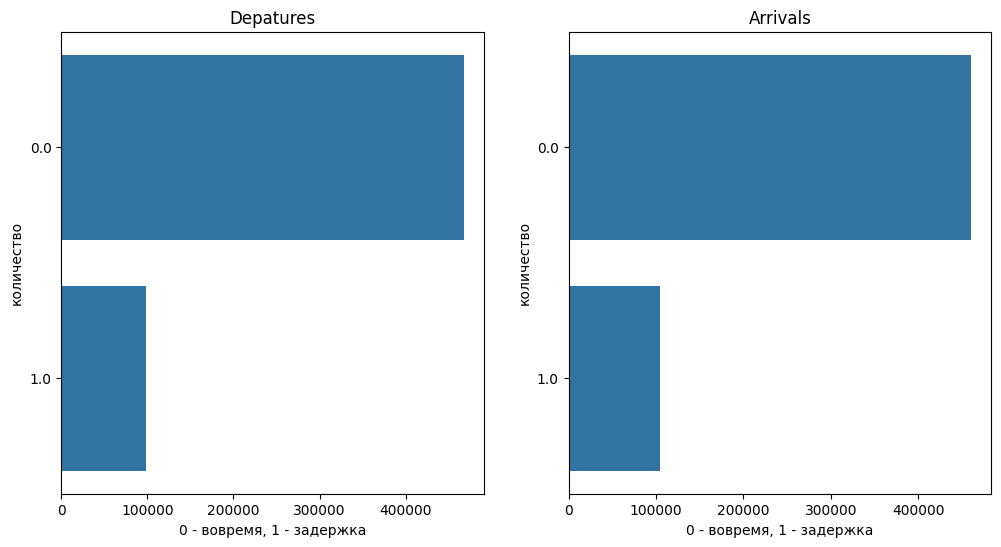

In [48]:
# Distribition рейсов с и без задержек
f, (ax,ax1) = plt.subplots(1,2, figsize=(12,6))
dep = sns.countplot(data['DEP_DEL15'], ax=ax)
dep.set_title('Depatures')
dep.set_xlabel('0 - вовремя, 1 - задержка')
dep.set_ylabel('количество')

arr = sns.countplot(data['ARR_DEL15'], ax=ax1)
arr.set_title('Arrivals')
arr.set_xlabel('0 - вовремя, 1 - задержка')
arr.set_ylabel('количество')

Можно заметить, что подавляющее большинство рейсов были выполнены без задержек. Также видно, что соотношение задержек в вылетах и прилетах одинаково.

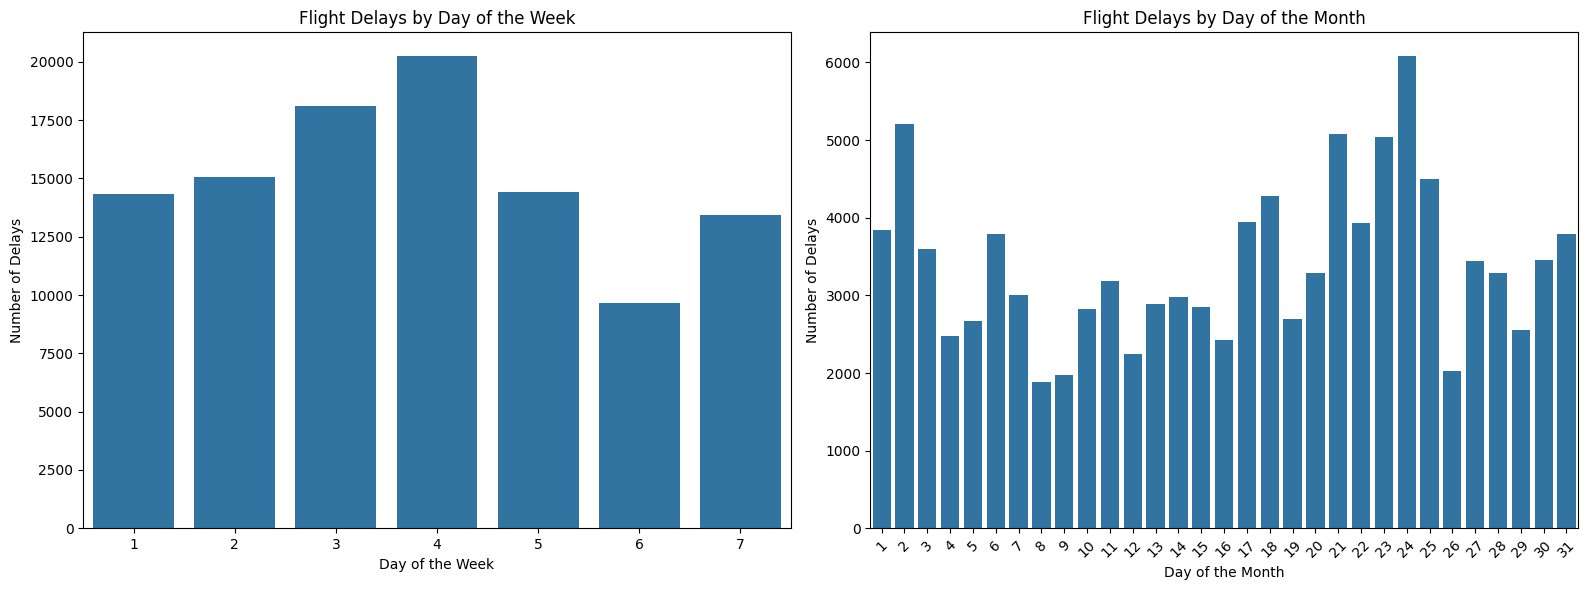

In [49]:
data['ARR_DEL15'] = data['ARR_DEL15'].astype(int)

# Group data by day of the week and sum delays
delays_by_day = data.groupby('DAY_OF_WEEK')['ARR_DEL15'].sum().reset_index()
delays_by_month = data.groupby('DAY_OF_MONTH')['ARR_DEL15'].sum().reset_index()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot delays by day of the week
sns.barplot(x='DAY_OF_WEEK', y='ARR_DEL15', data=delays_by_day, ax=axes[0])
axes[0].set_title('Flight Delays by Day of the Week')
axes[0].set_xlabel('Day of the Week')
axes[0].set_ylabel('Number of Delays')

# Plot delays by day of the month
sns.barplot(x='DAY_OF_MONTH', y='ARR_DEL15', data=delays_by_month, ax=axes[1])
axes[1].set_title('Flight Delays by Day of the Month')
axes[1].set_xlabel('Day of the Month')
axes[1].set_ylabel('Number of Delays')
axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


Заметно, что в четверг самое большое кол-во задержек, а также 2-х и 24-х числах января. Ниже, также можно посмотреть в какой час дня больше всех задержек.

In [12]:
# Количество задержек по часам
data['ARR_DEL15'] = data['ARR_DEL15'].astype(int)
time_blk = data[['DEP_TIME_BLK','ARR_DEL15']].groupby('DEP_TIME_BLK').sum().sort_values(by='ARR_DEL15',ascending=False)
time_blk['PERCENTUAL'] = time_blk['ARR_DEL15']/(time_blk['ARR_DEL15'].sum())*100
time_blk

,ARR_DEL15,PERCENTUAL
DEP_TIME_BLK,,
1700-1759,8270,7.859573
1800-1859,7978,7.582065
1600-1659,7576,7.200015
1400-1459,7290,6.928209
1500-1559,7281,6.919656
1900-1959,7219,6.860733
1200-1259,6639,6.309517
1300-1359,6398,6.080477
1100-1159,6361,6.045314


Большинство задержек происходит между 16:00 и 19:00, то есть после обеда и до вечера.

In [50]:
# В каких аэропортах вылета больше всех происходят задержки?
data['DEP_DEL15'] = data['DEP_DEL15'].astype(int)
origin_later = data[['ORIGIN','DEP_DEL15']].groupby('ORIGIN').sum().sort_values(by='DEP_DEL15',ascending=False)
origin_later['PERCENTUAL'] = origin_later['DEP_DEL15']/(origin_later['DEP_DEL15'].sum())*100
origin_later.head()

,DEP_DEL15,PERCENTUAL
ORIGIN,,
ORD,6560,6.673109
ATL,4118,4.189004
DFW,4028,4.097452
LGA,3775,3.840090
DEN,3415,3.473882


In [14]:
# В каких аэропортах прилета больше всех происходят задержки?
data['DEP_DEL15'] = data['DEP_DEL15'].astype(int)
dest_later = data[['DEST','ARR_DEL15']].groupby('DEST').sum().sort_values(by='ARR_DEL15',ascending=False)
dest_later['PERCENTUAL'] = dest_later['ARR_DEL15']/(dest_later['ARR_DEL15'].sum())*100
dest_later.head()

,ARR_DEL15,PERCENTUAL
DEST,,
ORD,6441,6.121343
LGA,4836,4.595997
DFW,4282,4.069491
ATL,3931,3.735911
SFO,3642,3.461253


Можно заметить, что 3 аэропорта лидируют в задержках по вылету и по прилету.

## Feature Engineering

Задержки вылета рейсов (DEP_DEL15) могут помочь нам смоделировать задержки прилета рейсов (ARR_DEL15). Таким образом, мы можем создать новые признаки:

- ARR_TIME_BLOCK с категоризацией точного времени прилета в часах

- Количество задержек относительно DEP_TIME_BLK, ARR_TIME_BLOCK

- Количество задержек DEP_DEL15 относительно ORIGIN аэропорта вылета

- Количество задержек ARR_DEL15 относительно DEST аэропорта вылета

In [45]:
# Convert 'ARR_TIME' to datetime if it's not already
data['ARR_TIME'] = pd.to_datetime(data['ARR_TIME'], format='%H%M', errors='coerce').dt.hour
# Create 'ARR_TIME_BLOCK' with hourly categories (0-23)
data['ARR_TIME_BLOCK'] = pd.cut(data['ARR_TIME'], bins=range(25), labels=False, include_lowest=True)
data.head()

,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,DISTANCE,DISTANCE_cat,ARR_TIME_BLOCK,DEP_DELAYS_BY_DEP_TIME_BLK,ARR_DELAYS_BY_ARR_TIME_BLK
0,1,2,GNV,ATL,601.0,0,0600-0659,NaN,0,300.0,"(30.999, 366.0]",NaN,2825,1097.0
1,1,2,MSP,CVG,1359.0,0,1400-1459,1.0,0,596.0,"(366.0, 642.0]",0.0,7279,6408.0
2,1,2,DTW,CVG,1215.0,0,1200-1259,1.0,0,229.0,"(30.999, 366.0]",0.0,6497,5635.0
3,1,2,TLH,ATL,1521.0,0,1500-1559,1.0,0,223.0,"(30.999, 366.0]",0.0,7240,6408.0
4,1,2,ATL,FSM,1847.0,0,1900-1959,1.0,0,579.0,"(366.0, 642.0]",0.0,7566,7773.0


In [44]:
data['DEP_DEL15'] = data['DEP_DEL15'].astype(int)
data['ARR_DEL15'] = data['ARR_DEL15'].astype(int)
# Feature 1: DEP_DEL15 delays according to DEP_TIME_BLK
dep_delays_by_time_blk = data.groupby('DEP_TIME_BLK')['DEP_DEL15'].sum().reset_index()
dep_delays_by_time_blk.rename(columns={'DEP_DEL15': 'DEP_DELAYS_BY_DEP_TIME_BLK'}, inplace=True)
data = pd.merge(data, dep_delays_by_time_blk, on='DEP_TIME_BLK', how='left')
# Dictionary for DEP_TIME_BLK to DEP_DELAYS_BY_DEP_TIME_BLK
dep_time_blk_dict = data.set_index('DEP_TIME_BLK')['DEP_DELAYS_BY_DEP_TIME_BLK'].to_dict()
print("DEP_TIME_BLK to DEP_DELAYS_BY_DEP_TIME_BLK:", dep_time_blk_dict)

# Feature 2: ARR_DEL15 delays according to ARR_TIME_BLOCK
arr_delays_by_time_blk = data.groupby('ARR_TIME_BLOCK')['ARR_DEL15'].sum().reset_index()
arr_delays_by_time_blk.rename(columns={'ARR_DEL15': 'ARR_DELAYS_BY_ARR_TIME_BLK'}, inplace=True)
data = pd.merge(data, arr_delays_by_time_blk, on='ARR_TIME_BLOCK', how='left')
# Dictionary for ARR_TIME_BLOCK to ARR_DELAYS_BY_ARR_TIME_BLK
arr_time_blk_dict = data.set_index('ARR_TIME_BLOCK')['ARR_DELAYS_BY_ARR_TIME_BLK'].to_dict()
print("ARR_TIME_BLOCK to ARR_DELAYS_BY_ARR_TIME_BLK:", arr_time_blk_dict)

data.head()

DEP_TIME_BLK to DEP_DELAYS_BY_DEP_TIME_BLK: {'0600-0659': 2825, '1400-1459': 7279, '1200-1259': 6497, '1500-1559': 7240, '1900-1959': 7566, '0900-0959': 4371, '1000-1059': 5465, '2000-2059': 5750, '1300-1359': 6402, '1100-1159': 5983, '0800-0859': 4054, '2200-2259': 2336, '1600-1659': 7342, '1700-1759': 8143, '2100-2159': 3889, '0700-0759': 3366, '1800-1859': 7894, '0001-0559': 1294, '2300-2359': 609}
ARR_TIME_BLOCK to ARR_DELAYS_BY_ARR_TIME_BLK: {6.0: 1097.0, 15.0: 6408.0, 12.0: 5635.0, 18.0: 7773.0, 8.0: 3347.0, 17.0: 7475.0, 11.0: 5328.0, 16.0: 7215.0, 21.0: 7526.0, 13.0: 6256.0, 14.0: 6055.0, 10.0: 5115.0, 0.0: 1002.0, 22.0: 6595.0, 7.0: 2146.0, 19.0: 7774.0, 9.0: 4832.0, 20.0: 8205.0, 2.0: 1068.0, 5.0: 547.0, 3.0: 860.0, 4.0: 910.0, 1.0: 1045.0, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan,

,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,DISTANCE,DISTANCE_cat,ARR_TIME_BLOCK,DEP_DELAYS_BY_DEP_TIME_BLK,ARR_DELAYS_BY_ARR_TIME_BLK
0,1,2,GNV,ATL,601.0,0,0600-0659,7.0,0,300.0,"(30.999, 366.0]",6.0,2825,1097.0
1,1,2,MSP,CVG,1359.0,0,1400-1459,16.0,0,596.0,"(366.0, 642.0]",15.0,7279,6408.0
2,1,2,DTW,CVG,1215.0,0,1200-1259,13.0,0,229.0,"(30.999, 366.0]",12.0,6497,5635.0
3,1,2,TLH,ATL,1521.0,0,1500-1559,16.0,0,223.0,"(30.999, 366.0]",15.0,7240,6408.0
4,1,2,ATL,FSM,1847.0,0,1900-1959,19.0,0,579.0,"(366.0, 642.0]",18.0,7566,7773.0


In [53]:
# Ensure 'DEP_DEL15' is of integer type
data['DEP_DEL15'] = data['DEP_DEL15'].astype(int)

# Group by 'ORIGIN' and sum 'DEP_DEL15' to calculate delay counts per origin
delays_per_origin = data.groupby('ORIGIN')['DEP_DEL15'].sum().reset_index()

# Rename the summed column to 'DEP_DELAYS_PER_ORIGIN'
delays_per_origin.rename(columns={'DEP_DEL15': 'DEP_DELAYS_PER_ORIGIN'}, inplace=True)

# Merge the delays per origin back into the original DataFrame
data = pd.merge(data, delays_per_origin, on='ORIGIN', how='left')

# Create the dictionary for ORIGIN to DEP_DELAYS_PER_ORIGIN
origin_dict = delays_per_origin.set_index('ORIGIN')['DEP_DELAYS_PER_ORIGIN'].to_dict()

# Print the dictionary to confirm correctness
print("ORIGIN to DEP_DELAYS_PER_ORIGIN mapping:", origin_dict)

# Display the first few rows of the DataFrame
data.head()


ORIGIN to DEP_DELAYS_PER_ORIGIN mapping: {'ABE': 49, 'ABI': 24, 'ABQ': 194, 'ABR': 7, 'ABY': 10, 'ACT': 8, 'ACV': 38, 'ACY': 18, 'ADK': 2, 'ADQ': 9, 'AEX': 22, 'AGS': 32, 'ALB': 172, 'ALO': 13, 'AMA': 40, 'ANC': 111, 'APN': 12, 'ART': 18, 'ASE': 318, 'ATL': 4118, 'ATW': 93, 'AUS': 658, 'AVL': 92, 'AVP': 33, 'AZA': 98, 'AZO': 27, 'BDL': 323, 'BET': 10, 'BFF': 3, 'BFL': 25, 'BGM': 14, 'BGR': 49, 'BHM': 204, 'BIL': 26, 'BIS': 55, 'BJI': 9, 'BLI': 20, 'BLV': 16, 'BMI': 40, 'BNA': 1105, 'BOI': 188, 'BOS': 2410, 'BPT': 11, 'BQK': 7, 'BQN': 49, 'BRD': 11, 'BRO': 18, 'BRW': 2, 'BTM': 4, 'BTR': 97, 'BTV': 180, 'BUF': 326, 'BUR': 335, 'BWI': 1276, 'BZN': 100, 'CAE': 87, 'CAK': 86, 'CDC': 6, 'CDV': 7, 'CGI': 17, 'CHA': 94, 'CHO': 76, 'CHS': 196, 'CID': 120, 'CIU': 13, 'CKB': 13, 'CLE': 730, 'CLL': 20, 'CLT': 2671, 'CMH': 612, 'CMI': 50, 'CMX': 9, 'CNY': 9, 'COD': 9, 'COS': 115, 'COU': 31, 'CPR': 2, 'CRP': 40, 'CRW': 58, 'CSG': 8, 'CVG': 717, 'CWA': 30, 'CYS': 6, 'DAB': 29, 'DAL': 996, 'DAY': 133,

,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,DISTANCE,DISTANCE_cat,ARR_TIME_BLOCK,DEP_DELAYS_BY_DEP_TIME_BLK,ARR_DELAYS_BY_ARR_TIME_BLK,DEP_DELAYS_PER_ORIGIN_x,ARR_DELAYS_PER_DEST,DEP_DELAYS_PER_ORIGIN_y,DEP_DELAYS_PER_ORIGIN
0,1,2,GNV,ATL,601.0,0,0600-0659,NaN,0,300.0,"(30.999, 366.0]",NaN,2825,1097.0,46,3931,46,46
1,1,2,MSP,CVG,1359.0,0,1400-1459,1.0,0,596.0,"(366.0, 642.0]",0.0,7279,6408.0,1849,743,1849,1849
2,1,2,DTW,CVG,1215.0,0,1200-1259,1.0,0,229.0,"(30.999, 366.0]",0.0,6497,5635.0,2200,743,2200,2200
3,1,2,TLH,ATL,1521.0,0,1500-1559,1.0,0,223.0,"(30.999, 366.0]",0.0,7240,6408.0,50,3931,50,50
4,1,2,ATL,FSM,1847.0,0,1900-1959,1.0,0,579.0,"(366.0, 642.0]",0.0,7566,7773.0,4118,22,4118,4118


In [54]:
data['ARR_DEL15'] = data['ARR_DEL15'].astype(int)
# Group by 'DEST' and sum 'ARR_DEL15' to get delay counts per destination
delays_per_dest = data.groupby('DEST')['ARR_DEL15'].sum().reset_index()

# Rename the summed column to 'ARR_DELAYS_PER_DEST'
delays_per_dest.rename(columns={'ARR_DEL15': 'ARR_DELAYS_PER_DEST'}, inplace=True)

# Merge this information back into the original DataFrame 'data'
data = pd.merge(data, delays_per_dest, on='DEST', how='left')

# Dictionary for DEST to ARR_DELAYS_PER_DEST
dest_dict = delays_per_dest.set_index('DEST')['ARR_DELAYS_PER_DEST'].to_dict()
print("DEST to ARR_DELAYS_PER_DEST:", dest_dict)

data.head()

DEST to ARR_DELAYS_PER_DEST: {'ABE': 64, 'ABI': 24, 'ABQ': 246, 'ABR': 9, 'ABY': 10, 'ACT': 9, 'ACV': 31, 'ACY': 34, 'ADK': 1, 'ADQ': 12, 'AEX': 37, 'AGS': 29, 'ALB': 196, 'ALO': 18, 'AMA': 77, 'ANC': 146, 'APN': 7, 'ART': 10, 'ASE': 307, 'ATL': 3931, 'ATW': 93, 'AUS': 745, 'AVL': 103, 'AVP': 37, 'AZA': 157, 'AZO': 32, 'BDL': 401, 'BET': 8, 'BFF': 9, 'BFL': 31, 'BGM': 10, 'BGR': 58, 'BHM': 259, 'BIL': 43, 'BIS': 76, 'BJI': 8, 'BLI': 34, 'BLV': 15, 'BMI': 34, 'BNA': 1054, 'BOI': 240, 'BOS': 2688, 'BPT': 14, 'BQK': 9, 'BQN': 52, 'BRD': 11, 'BRO': 30, 'BRW': 5, 'BTM': 3, 'BTR': 98, 'BTV': 177, 'BUF': 361, 'BUR': 314, 'BWI': 1020, 'BZN': 94, 'CAE': 100, 'CAK': 133, 'CDC': 9, 'CDV': 8, 'CGI': 25, 'CHA': 143, 'CHO': 79, 'CHS': 289, 'CID': 128, 'CIU': 11, 'CKB': 16, 'CLE': 804, 'CLL': 17, 'CLT': 2648, 'CMH': 709, 'CMI': 61, 'CMX': 14, 'CNY': 10, 'COD': 13, 'COS': 142, 'COU': 56, 'CPR': 3, 'CRP': 57, 'CRW': 66, 'CSG': 8, 'CVG': 743, 'CWA': 30, 'CYS': 5, 'DAB': 31, 'DAL': 777, 'DAY': 201, 'DBQ'

,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,DISTANCE,DISTANCE_cat,ARR_TIME_BLOCK,DEP_DELAYS_BY_DEP_TIME_BLK,ARR_DELAYS_BY_ARR_TIME_BLK,DEP_DELAYS_PER_ORIGIN_x,ARR_DELAYS_PER_DEST_x,DEP_DELAYS_PER_ORIGIN_y,DEP_DELAYS_PER_ORIGIN,ARR_DELAYS_PER_DEST_y
0,1,2,GNV,ATL,601.0,0,0600-0659,NaN,0,300.0,"(30.999, 366.0]",NaN,2825,1097.0,46,3931,46,46,3931
1,1,2,MSP,CVG,1359.0,0,1400-1459,1.0,0,596.0,"(366.0, 642.0]",0.0,7279,6408.0,1849,743,1849,1849,743
2,1,2,DTW,CVG,1215.0,0,1200-1259,1.0,0,229.0,"(30.999, 366.0]",0.0,6497,5635.0,2200,743,2200,2200,743
3,1,2,TLH,ATL,1521.0,0,1500-1559,1.0,0,223.0,"(30.999, 366.0]",0.0,7240,6408.0,50,3931,50,50,3931
4,1,2,ATL,FSM,1847.0,0,1900-1959,1.0,0,579.0,"(366.0, 642.0]",0.0,7566,7773.0,4118,22,4118,4118,22


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565963 entries, 0 to 565962
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   DAY_OF_MONTH                565963 non-null  category
 1   DAY_OF_WEEK                 565963 non-null  category
 2   ORIGIN                      565963 non-null  object  
 3   DEST                        565963 non-null  object  
 4   DEP_TIME                    565963 non-null  float64 
 5   DEP_DEL15                   565963 non-null  int64   
 6   DEP_TIME_BLK                565963 non-null  object  
 7   ARR_TIME                    464070 non-null  float64 
 8   ARR_DEL15                   565963 non-null  int64   
 9   DISTANCE                    565963 non-null  float64 
 10  DISTANCE_cat                565963 non-null  category
 11  ARR_TIME_BLOCK              464070 non-null  float64 
 12  DEP_DELAYS_BY_DEP_TIME_BLK  565963 non-null  int64   
 13 

# Тренировка модели

Для тренировки взяты несколько базовых моделей вместе с GridSearchCV. Категорические признаки были раскрыты через label encoding. Признаки аэропортов были раскрыты с one-hot encoding.

Далее был сделан train-val-test split для тренироваки, валидации и тестирования модели.

## Подготовка данных

In [15]:
# 1. Get a list of columns to one-hot encode
columns_to_encode = data.select_dtypes(include=['category']).columns.tolist()
columns_to_encode.append('ORIGIN')
columns_to_encode.append('DEST')
columns_to_encode.append('DEP_TIME_BLK')

# 2. Create a OneHotEncoder object
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # sparse=False for dense output

# 3. Fit and transform the selected columns
encoded_data = encoder.fit_transform(data[columns_to_encode])

# 4. Create a DataFrame from the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_encode))
encoded_df = encoded_df.astype(np.int8)

# 5. Concatenate the encoded DataFrame with the original DataFrame
data = pd.concat([data, encoded_df], axis=1)

# 6. Drop the original categorical columns (optional)
data.drop(columns_to_encode, axis=1, inplace=True)

# Optimize data types
for col in data.select_dtypes(include=np.number).columns:
    if data[col].dtype == np.float64:
        data[col] = data[col].astype(np.float32)  # Downcast to float32
    elif data[col].dtype == np.int64:
        data[col] = data[col].astype(np.int32)  # Downcast to int32

data = data.drop(['DEP_TIME', 'ARR_TIME', 'DISTANCE'], axis=1)


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96951 entries, 0 to 96950
Columns: 757 entries, DEP_DEL15 to DEP_TIME_BLK_2300-2359
dtypes: float32(2), int32(5), int8(750)
memory usage: 71.9 MB


## Разделение датасета

In [17]:
#Train Val Test Split

# Split into train and rest (80% train)
train_data, rest_data = train_test_split(data, test_size=0.2, random_state=42)

# Split the rest into validation and test (10% each)
val_data, test_data = train_test_split(rest_data, test_size=0.5, random_state=42)

X_train = train_data.drop('ARR_DEL15', axis=1)
y_train = train_data['ARR_DEL15']

X_val = val_data.drop('ARR_DEL15', axis=1)
y_val = val_data['ARR_DEL15']

X_test = test_data.drop('ARR_DEL15', axis=1)
y_test = test_data['ARR_DEL15']

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training data and transform
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [27]:
# Find indices of rows with missing values in X_train_scaled
missing_indices_train = np.where(np.isnan(X_train_scaled).any(axis=1))[0]

# Remove rows with missing values from X_train_scaled and y_train
X_train_scaled = np.delete(X_train_scaled, missing_indices_train, axis=0)
y_train = y_train.drop(index=y_train.index[missing_indices_train]).reset_index(drop=True)

# Repeat for X_val_scaled, y_val and X_test_scaled, y_test
missing_indices_val = np.where(np.isnan(X_val_scaled).any(axis=1))[0]
X_val_scaled = np.delete(X_val_scaled, missing_indices_val, axis=0)
y_val = y_val.drop(index=y_val.index[missing_indices_val]).reset_index(drop=True)

missing_indices_test = np.where(np.isnan(X_test_scaled).any(axis=1))[0]
X_test_scaled = np.delete(X_test_scaled, missing_indices_test, axis=0)
y_test = y_test.drop(index=y_test.index[missing_indices_test]).reset_index(drop=True)

## Тренировка и Evaluation моделей

In [30]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Define parameter grid
param_grid_lr = {
    'C': [0.1, 1, 10],
    'max_iter': [100]
}

# Initialize Logistic Regression and GridSearchCV
lr = LogisticRegression(random_state=42)
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1)

# Train model
grid_search_lr.fit(X_train_scaled, y_train)

# Evaluate on validation set
y_val_pred_lr = grid_search_lr.predict(X_val_scaled)
y_val_proba_lr = grid_search_lr.predict_proba(X_val_scaled)[:, 1]

print("Best Parameters:", grid_search_lr.best_params_)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred_lr))
print("Validation ROC AUC Score:", roc_auc_score(y_val, y_val_proba_lr))

Best Parameters: {'C': 0.1, 'max_iter': 100}
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7846
           1       0.81      0.74      0.77      1808

    accuracy                           0.92      9654
   macro avg       0.88      0.85      0.86      9654
weighted avg       0.92      0.92      0.92      9654

Validation ROC AUC Score: 0.8849301628246399


In [33]:
# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

# Define parameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7]
}

# Initialize KNN and GridSearchCV
knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5, scoring='roc_auc', n_jobs=-1)

# Train model
grid_search_knn.fit(X_train_scaled, y_train)

# Evaluate on validation set
y_val_pred_knn = grid_search_knn.predict(X_val_scaled)
y_val_proba_knn = grid_search_knn.predict_proba(X_val_scaled)[:, 1]

print("Best Parameters:", grid_search_knn.best_params_)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred_knn))
print("Validation ROC AUC Score:", roc_auc_score(y_val, y_val_proba_knn))


Best Parameters: {'n_neighbors': 7}
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      7846
           1       0.60      0.16      0.26      1808

    accuracy                           0.82      9654
   macro avg       0.72      0.57      0.58      9654
weighted avg       0.79      0.82      0.78      9654

Validation ROC AUC Score: 0.7048225351286603


In [34]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

# Define parameter grid
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Decision Tree and GridSearchCV
dt = DecisionTreeClassifier(random_state=42)
grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

# Train model
grid_search_dt.fit(X_train_scaled, y_train)

# Evaluate on validation set
y_val_pred_dt = grid_search_dt.predict(X_val_scaled)
y_val_proba_dt = grid_search_dt.predict_proba(X_val_scaled)[:, 1]

print("Best Parameters:", grid_search_dt.best_params_)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred_dt))
print("Validation ROC AUC Score:", roc_auc_score(y_val, y_val_proba_dt))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'max_depth': 10}
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7846
           1       0.81      0.74      0.77      1808

    accuracy                           0.92      9654
   macro avg       0.87      0.85      0.86      9654
weighted avg       0.92      0.92      0.92      9654

Validation ROC AUC Score: 0.8741405701907743


In [35]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Define parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize Random Forest and GridSearchCV
rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

# Train model
grid_search_rf.fit(X_train_scaled, y_train)

# Evaluate on validation set
y_val_pred_rf = grid_search_rf.predict(X_val_scaled)
y_val_proba_rf = grid_search_rf.predict_proba(X_val_scaled)[:, 1]

print("Best Parameters:", grid_search_rf.best_params_)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred_rf))
print("Validation ROC AUC Score:", roc_auc_score(y_val, y_val_proba_rf))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7846
           1       0.83      0.74      0.78      1808

    accuracy                           0.92      9654
   macro avg       0.88      0.85      0.87      9654
weighted avg       0.92      0.92      0.92      9654

Validation ROC AUC Score: 0.9286844911673612


Самой аккуратной и эффективной моделью является Random Forest. Ее мы будем использовать для deployment.

# Подготовка для Deployment

Ниже я формирую файл модели, скейлер, а также словари переменных для автоматического преобразования вводных данных пользователя в нужный формат для модели.

In [36]:
import joblib

# Save the best model (e.g., Random Forest)
best_model = grid_search_rf.best_estimator_

# Save the model to a file
joblib.dump(best_model, 'best_model.pkl')

# Save the scaler if used
joblib.dump(scaler, 'scaler.pkl')

print("Model and Scaler saved successfully!")

Model and Scaler saved successfully!


In [50]:
df = pd.read_csv('/content/Jan_2019_ontime.csv')

# Extract unique values for ORIGIN and DEST
origin_list = df['ORIGIN'].unique().tolist()
dest_list = df['DEST'].unique().tolist()

# Sort the lists for better readability
origin_list.sort()
dest_list.sort()

In [55]:
# Save dictionaries to a Python file
with open('dictionaries.py', 'w') as f:
    f.write(f"dep_time_blk_dict = {dep_time_blk_dict}\n")
    f.write(f"arr_time_blk_dict = {arr_time_blk_dict}\n")
    f.write(f"origin_dict = {origin_dict}\n")
    f.write(f"dest_dict = {dest_dict}\n")

# Заключение

Лучшей моделью для предсказания Flight delay была Random Forest. В перспективе, можно взять более широкий датасет с данными о погоде и таким образом усилить модель. Также, можно попробовать использовать модели глубинного обучения и LSTM для учитывания динамических данных (например, вероятность задержки может увеличиваться если в аэропорту несколько рейсов перед исследуемым рейсом подверглись задержке). Более того, можно увеличить кол-во классов вместо "будет ли задержка дольше 15 мин" на классы >5, >15, >30, >60 мин. Для этого нужны большие вычислительные ресурсы и бесперебойный доступ к GPU, который был у меня ограничен бесплатной версией Google Colab.
